# How to use fuvpy

fuvpy is a collection of functions to analyse and visualize auroral images.
The images are stored as xarray.Datasets and fuvpy includes a function to read .idl/.sav file generated with fuview3 or xvis (IMAGE and Polar softwave) into this format.

Images are loaded as follows:

In [1]:
import fuvpy as fuv
import pandas as pd
import numpy as np
import glob
import warnings
import matplotlib.pyplot as plt
from polplot import pp

warnings.filterwarnings("ignore",category =RuntimeWarning) # Turn of all the warnings when np.where contains NaNs. 

path = '../data/wicFiles/'
wicfiles = glob.glob(path + '*.idl')
wic = fuv.readImg(wicfiles)
wic


Bad key "text.kerning_factor" on line 4 in
/Users/aohma/anaconda3/envs/lompe-env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


<xarray.Dataset>
Dimensions:     (date: 15, row: 256, col: 256)
Coordinates:
  * date        (date) datetime64[ns] 2000-08-28T09:28:42 ... 2000-08-28T09:5...
Dimensions without coordinates: row, col
Data variables:
    img         (date, row, col) float32 684.7 723.2 689.4 ... -485.1 -485.1
    mlat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlt         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    dza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    sza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    hemisphere  (date) <U5 'north' 'north' 'north' ... 'north' 'north' 'north'
    id          <U3 'WIC'
    bad         (row, col) bool False False False False ... False False False

There are two ways to select images, by label or by index:

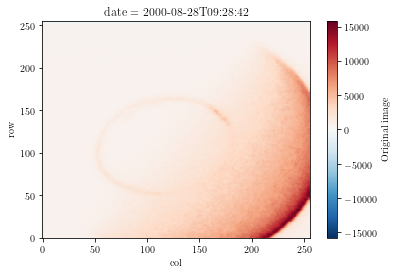

In [2]:
wic.sel(date='2000-08-28 09:28:42')['img'].plot()

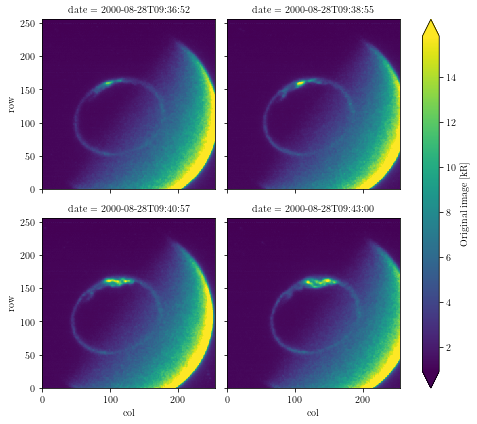

In [3]:
wic = fuv.getRayleigh(wic,'img')
wic.isel(date=slice(4,8))['imgR'].plot(x='col', y='row', col='date', col_wrap=2,robust=True)

In the same way we can visualize for instance the viewing anlge for these images:

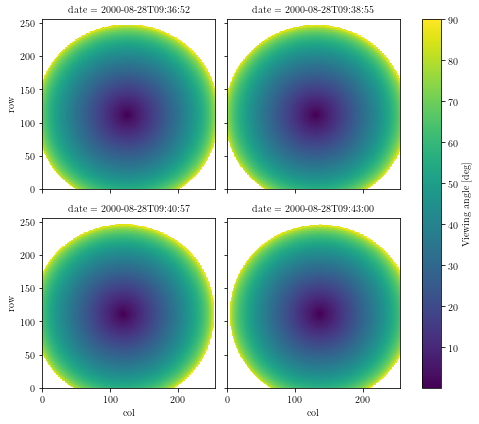

In [4]:
wic.isel(date=slice(4,8))['dza'].plot(x='col', y='row', col='date', col_wrap=2)

Note how the name and units of the variables appear automatically in the figures. They are added to each variable, and can be accessed (and assigned) using wic['nameofvariable'].attrs.

The images can be projected into polar coordinates by using polplot. fuv.plotimg is a wrapper to polplot's plotimg, and can be used as follows:

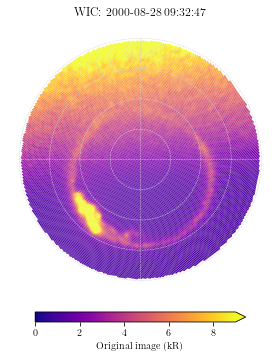

In [5]:
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = pp(ax)
fuv.plotimg(wic.isel(date=6),'imgR',pax=pax,crange=(0,9),cmap='plasma')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='max')
cbar.set_label('{} ({})'.format(wic['imgR'].attrs['long_name'],wic['imgR'].attrs['units']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=6)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

In the above example, plotimg only does the polar projection and all other aspects of the plot must be done manually (like colorbar, title etc.). This is handy in subplots or when fine-tuning is needed. However, we sometimes just want a quick look at the images. This can be done using fuvpy.pplot, which resembles some of the functionality of xarrays 2D plot. 

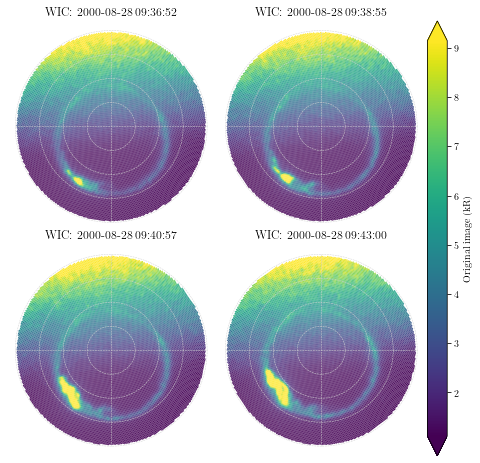

In [6]:
fuv.pplot(wic.isel(date=slice(4,8)),'imgR', col_wrap=2,robust=True,cbar_kwargs={'extend':'both'})

The images can also be plotted in an mlt-mlat projection. 

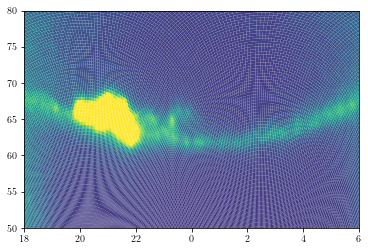

In [7]:
fuv.plotimgProj(wic.isel(date=6),inImg='img',crange=(0,4000))

Time to remove the dayglow. A simple version of the method is described in the appendix of *Ohma et al.* (2018), but the present version is more advanced and inludes a temporal fit using B-slines. Going retro, we use the colormap from the IMAGE mission. 

Building dayglow G matrix
Iteration: 0
Iteration: 1
Relative change model norm 0.010038960872704342
Iteration: 2
Relative change model norm 0.003342068533300038
Iteration: 3
Relative change model norm 0.0011762133503120697
Iteration: 4
Relative change model norm 0.0004882252928980204


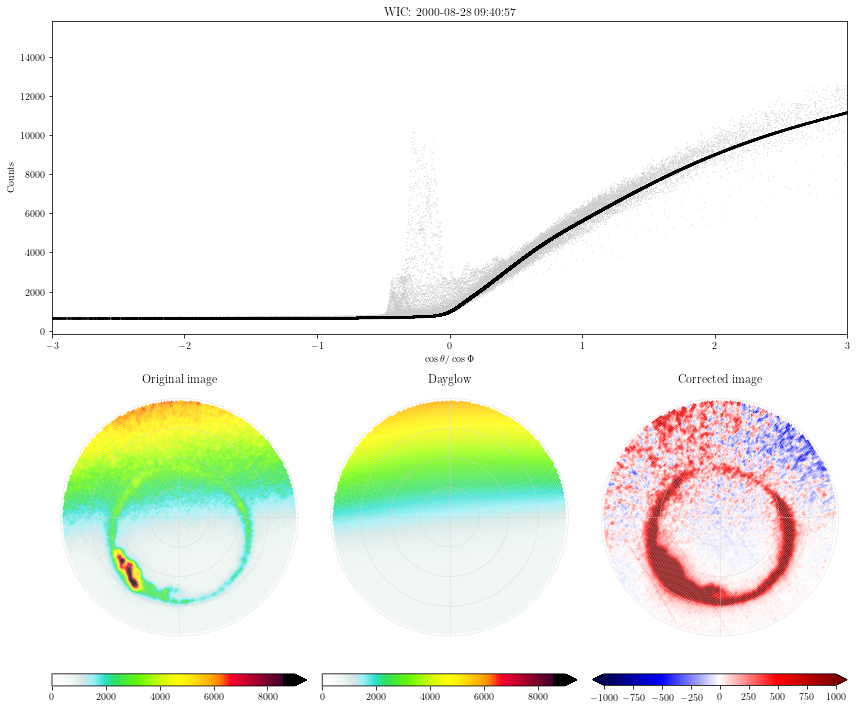

In [8]:
wic = fuv.makeDGmodel(wic,transform='log',tOrder=1)
fuv.showDGmodel(wic.isel(date=6),cmap=fuv.getIMAGEcmap())

Dayglow is subtracted, but the image is not perfect (note the asymmetry at the dayside). We model the residual background using a spherical harmonics model. Note the use of Dataset.pipe, which is handy for chained function calls.

Building sh G matrix
Iteration: 0
Iteration: 1
Relative change model norm: 0.11132331915131109
Iteration: 2
Relative change model norm: 0.023747589974082103
Iteration: 3
Relative change model norm: 0.018501923178715407
Iteration: 4
Relative change model norm: 0.01346359752348149
Iteration: 5
Relative change model norm: 0.008671706953902724
Iteration: 6
Relative change model norm: 0.005255244817690664
Iteration: 7
Relative change model norm: 0.0030828373328405123
Iteration: 8
Relative change model norm: 0.001775852523892434
Iteration: 9
Relative change model norm: 0.0010126094018752287
Iteration: 10
Relative change model norm: 0.0005742801854060615


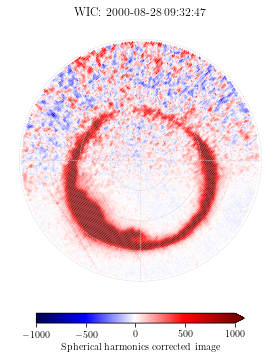

In [9]:
wic = wic.pipe(fuv.makeSHmodel,4,4,order=0)

# Figure
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = pp(ax)
fuv.plotimg(wic.isel(date=6),'shimg',pax=pax,crange=(-1000,1000),cmap='seismic')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='max')
cbar.set_label('{}'.format(wic['shimg'].attrs['long_name']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=2)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

This is staring to look great! To further examine the performance of the background subtraction, we plot the background corrected counts (residual counts) vs solar zenith angle and and the original vs modelled counts:

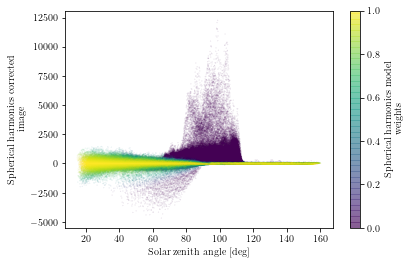

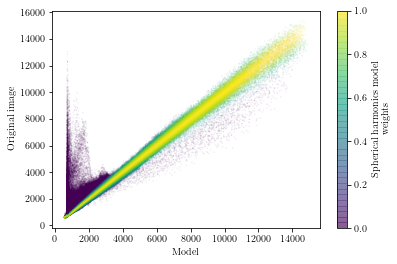

In [10]:
plt.figure()
wic.plot.scatter(x='sza',y='shimg',hue='shweight',s=0.01,alpha=0.4)
wic['Model'] = wic['dgmodel'] + wic['shmodel']
plt.figure()
wic.plot.scatter(x='Model',y='img',hue='shweight',s=0.01,alpha=0.4)

A two step approach to model the auroral boundaries is included in fuvpy. The first step identifies significant peaks in 24 1-hr wide MLT sectors in each image individually. Based on these boundaries, the second step makes a spatiotemporal model of the boundaries using radial Fourier serier (space) and B-splines (time). This model is smooth and differentiable at any MLT location in the time interval spanned by the input images.

Image: 0
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image: 8
Image: 9
Image: 10
Image: 11
Image: 12
Image: 13
Image: 14
Iteration: 0
Iteration: 1
Relative change model norm 0.006425937616019654
Iteration: 2
Relative change model norm 0.003030699996019254
Iteration: 3
Relative change model norm 0.0016768090703667333
Iteration: 4
Relative change model norm 0.0008822850419532548
Iteration: 0
Iteration: 1
Relative change model norm 0.03158228286447775
Iteration: 2
Relative change model norm 0.0028477146951900382
Iteration: 3
Relative change model norm 0.0017170058236142562
Iteration: 4
Relative change model norm 0.0009018634940255948


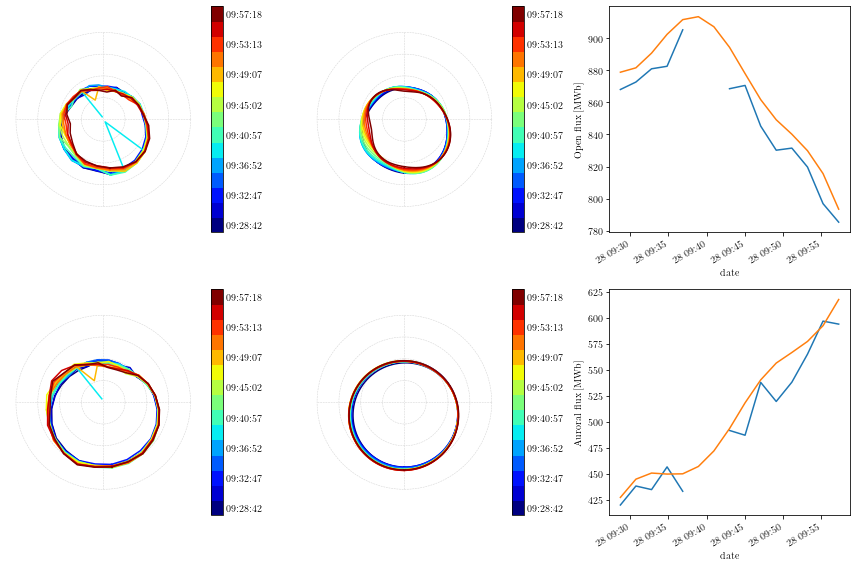

In [11]:
bi = fuv.findBoundaries(wic)
bm = fuv.makeBoundaryModel(bi,dampingValE=0.01,dampingValP=0.01)
fi= fuv.calcFlux(bi.sel(lim=1))
fm= fuv.calcFlux(bm)

fig,axs = plt.subplots(2,3,figsize=(12,8))

#Poleward boundary
pax00 = pp(axs[0][0])
fuv.ppBoundaries(bi.sel(lim=1),'ocb',pax=pax00)
pax01 = pp(axs[0][1])
fuv.ppBoundaries(bm,'ocb',pax=pax01)
fi['openFlux'].plot(ax=axs[0][2])
fm['openFlux'].plot(ax=axs[0][2])

# Equatorward boundary
pax10 = pp(axs[1][0])
fuv.ppBoundaries(bi.sel(lim=1),'eqb',pax=pax10)
pax11 = pp(axs[1][1])
fuv.ppBoundaries(bm,'eqb',pax=pax11)
fi['auroralFlux'].plot(ax=axs[1][2])
fm['auroralFlux'].plot(ax=axs[1][2])
plt.tight_layout()
plt.tight_layout()                       

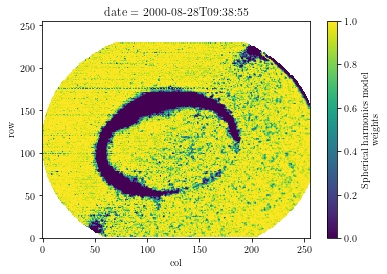

In [12]:
wic.isel(date=5)['shweight'].plot()

(-5, 5)

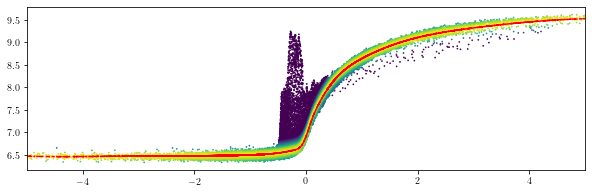

In [33]:
plt.figure(figsize=(10,3))
x = np.cos(np.deg2rad(wic.isel(date=6)['sza'].values.flatten()))/np.cos(np.deg2rad(wic.isel(date=6)['dza'].values.flatten()))
y = np.log(wic.isel(date=6)['img'].values.flatten())
w = wic.isel(date=6)['dgweight'].values.flatten()
m = np.log(wic.isel(date=6)['dgmodel'].values.flatten())

y = y[x.argsort()]
w = w[x.argsort()]
m = m[x.argsort()]
x = x[x.argsort()]

plt.scatter(x,y,c=w,s=0.5)
plt.plot(x,m,c='r')
plt.xlim([-5,5])       